In [2]:
using Knet, Plots, Images

# Linear regression example with housing data

In [3]:
# Download the housing dataset from the UCI Machine Learning Repository
include(Pkg.dir("Knet","data","housing.jl"))
x,y = housing()
map(summary,(x,y))

INFO: Downloading https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data to /home/jon/.julia/v0.6/Knet/data/housing/housing.data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49082  100 49082    0     0  78749      0 --:--:-- --:--:-- --:--:-- 78657


("13×506 Array{Float64,2}", "1×506 Array{Float64,2}")

In [5]:
# Define loss
predict(w,x) = w[1]*x .+ w[2]
loss(w,x,y) = mean(abs2,y-predict(w,x))
lossgradient = grad(loss);

In [6]:
# Initialize model
srand(42)
w = [ 0.1*rand(1,13), 0.0 ]

2-element Array{Any,1}:
  [0.0533183 0.0454029 … 0.0160006 0.0422956]
 0.0                                         

In [8]:
loss(w,x,y)

594.4352393887679

In [9]:
lossgradient(w,x,y)

2-element Array{Any,1}:
    [7.53003 -6.79923 … -6.369 13.8655]
 -45.0656                              

In [10]:
# Testing the gradient: Increasing w[2] by eps should decrease loss by 45.0656 * eps
w[2]=0.1

0.1

In [11]:
loss(w,x,y)

589.9386781239456

In [12]:
# SGD training loop
function train!(w, data; lr=.1)
    for (x,y) in data
        dw = lossgradient(w, x, y)
        for i in 1:length(w)
            w[i] -= lr * dw[i]
        end
    end
    return w
end

train! (generic function with 1 method)

In [13]:
# Record the weights for 10 epochs
@time weights = [ copy(train!(w, [(x, y)])) for epoch=1:10 ]

  0.215568 seconds (440.65 k allocations: 17.270 MiB, 4.48% gc time)


10-element Array{Array{Any,1},1}:
 Any[[-0.699684 0.725326 … 0.652901 -1.34426], 4.58656]
 Any[[-0.551026 0.513913 … 0.565058 -1.53221], 8.17581]
 Any[[-0.59464 0.518516 … 0.634074 -1.88846], 11.0472] 
 Any[[-0.590579 0.487521 … 0.663802 -2.1303], 13.3443] 
 Any[[-0.594767 0.473771 … 0.698189 -2.33759], 15.182] 
 Any[[-0.596189 0.463224 … 0.727585 -2.50545], 16.6522]
 Any[[-0.598128 0.457414 … 0.754282 -2.64491], 17.8283]
 Any[[-0.600288 0.454846 … 0.777929 -2.7612], 18.7692] 
 Any[[-0.602933 0.455003 … 0.798796 -2.8591], 19.5219] 
 Any[[-0.606062 0.457353 … 0.817038 -2.94219], 20.1241]

In [14]:
losses = [ loss(w,x,y) for w in weights ]

10-element Array{Float64,1}:
 364.412 
 240.165 
 161.982 
 112.161 
  80.3404
  59.9844
  46.9397
  38.5626
  33.1684
  29.6825

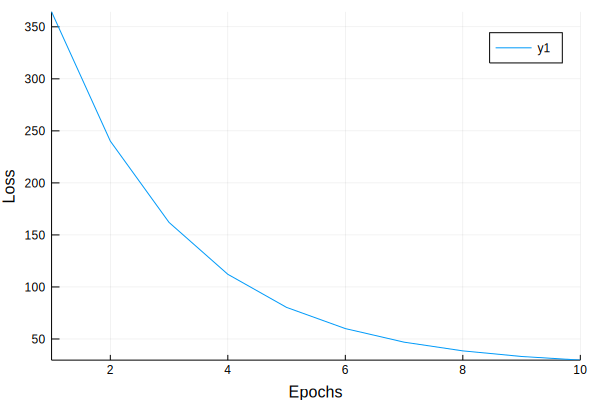

In [17]:
plot(losses,xlabel="Epochs",ylabel="Loss") 

# Load and minibatch MNIST data

In [18]:
include(Knet.dir("data","mnist.jl"))
xtrn,ytrn,xtst,ytst = mnist()
Atype = gpu() >= 0 ? KnetArray{Float32} : Array{Float32}
dtst = minibatch(xtst,ytst,100;xtype=Atype); # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype); # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100

In [20]:
# dtrn and dtst are iterables of (x,y) minibatches, each minibatch contains 100 instances
length(dtrn),length(dtst)

(600, 100)

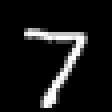

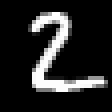

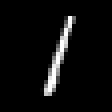

3-element Array{UInt8,1}:
 0x07
 0x02
 0x01

In [22]:
# Take a look at the first three test images and labels
(x,y) = first(dtst)
ax = Array(x)
for i=1:3; display(mnistview(ax,i)); end
y[1:3]

# Softmax classification example with MNIST

## Define softmax loss

In [27]:
# Define loss
predict(w,x) = w[1]*mat(x) .+ w[2]  # Same as linreg except we need mat() to convert input 4D->2D before matmul
loss(w,x,ygold) = nll(predict(w,x),ygold); # nll is negative log likelihood

In [28]:
# Initialize model
wsoft=map(Atype, [ 0.1*randn(10,784), zeros(10,1) ]);

In [30]:
# Average loss for a single (x,y) minibatch
loss(wsoft, x, y)

2.830448f0

In [31]:
# Average loss for the whole test set
nll(wsoft,dtst,predict)

2.8376572f0

In [32]:
# Accuracy for the whole test set
accuracy(wsoft,dtst,predict)

0.0407

## Train softmax model

In [33]:
@time softmodels = [ copy(train!(wsoft, dtrn)) for epoch=1:60 ];  # ~17 seconds

 27.146815 seconds (23.55 M allocations: 19.056 GiB, 6.95% gc time)


## Plot softmax learning curve

In [34]:
@time trnsoftloss = [ nll(w,dtrn,predict) for w in softmodels ];  # ~13 seconds
@time tstsoftloss = [ nll(w,dtst,predict) for w in softmodels ];  # ~2 seconds

  7.467384 seconds (5.20 M allocations: 11.492 GiB, 13.65% gc time)
  1.332153 seconds (874.87 k allocations: 1.916 GiB, 13.19% gc time)


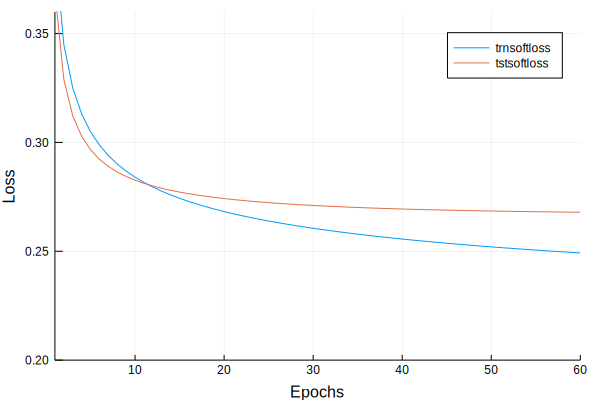

In [36]:
plot([trnsoftloss tstsoftloss],ylim=(.2,.36),labels=[:trnsoftloss :tstsoftloss],xlabel="Epochs",ylabel="Loss") 

## Plot softmax error rate

In [37]:
@time trnsofterr = [ 1-accuracy(w,dtrn,predict) for w in softmodels ];  # ~12 seconds
@time tstsofterr = [ 1-accuracy(w,dtst,predict) for w in softmodels ];  # ~2 seconds

  6.153225 seconds (3.33 M allocations: 11.134 GiB, 15.74% gc time)
  1.062067 seconds (562.73 k allocations: 1.856 GiB, 15.49% gc time)


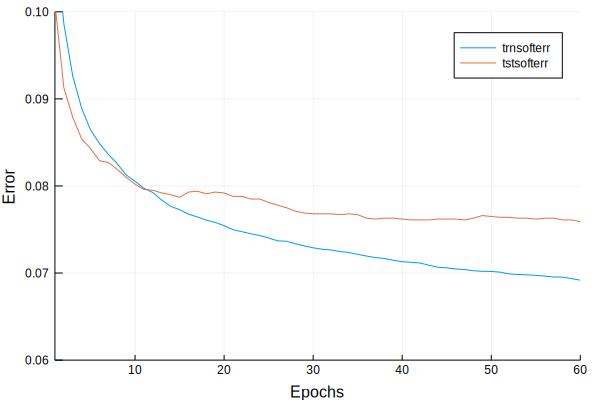

In [39]:
plot([trnsofterr tstsofterr],ylim=(.06,.10),labels=[:trnsofterr :tstsofterr],xlabel="Epochs",ylabel="Error")

In [40]:
# Cleanup
wsoft = softmodels = nothing; knetgc()

# Multilayer perceptron example with MNIST

In [41]:
# We only need to change the predict function!
function predict(w,x)
    for i=1:2:length(w)
        x = w[i]*mat(x) .+ w[i+1]
        if i<length(w)-1
            x = max.(0,x)                         
        end
    end
    return x
end

predict (generic function with 1 method)

In [43]:
wmlp=map(Atype, [ 0.1*randn(64,784), zeros(64,1), 
                  0.1*randn(10,64),  zeros(10,1) ])
loss(wmlp, x, y)  # average loss for random model should be close to log(10)=2.3026

2.4366724f0

## Train MLP model

In [44]:
@time mlpmodels = [ copy(train!(wmlp, dtrn)) for epoch=1:60 ]; # ~20 seconds

 60.059827 seconds (39.31 M allocations: 58.845 GiB, 9.66% gc time)


## Compare MLP loss with softmax loss

In [45]:
@time trnmlploss = [ nll(w,dtrn,predict) for w in mlpmodels ]; # ~12 seconds
@time tstmlploss = [ nll(w,dtst,predict) for w in mlpmodels ]; # ~2 seconds

 13.244330 seconds (7.18 M allocations: 14.151 GiB, 10.61% gc time)
  2.302616 seconds (1.20 M allocations: 2.359 GiB, 10.41% gc time)


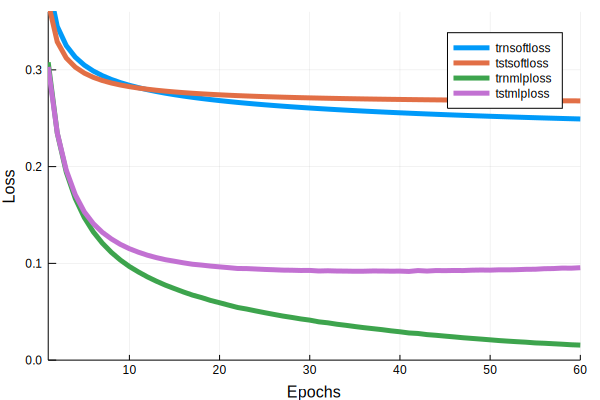

In [50]:
plot([trnsoftloss tstsoftloss trnmlploss tstmlploss],
    xlabel="Epochs",ylabel="Loss",linewidth=5,ylim=(.0,.36),
    labels=[:trnsoftloss :tstsoftloss :trnmlploss :tstmlploss]) 

## Compare MLP error with softmax error

In [51]:
@time trnmlperr = [ 1-accuracy(w,dtrn,predict) for w in mlpmodels ]; # ~13 seconds
@time tstmlperr = [ 1-accuracy(w,dtst,predict) for w in mlpmodels ]; # ~2 seconds

 10.386532 seconds (5.31 M allocations: 13.793 GiB, 12.48% gc time)
  1.744261 seconds (892.73 k allocations: 2.299 GiB, 12.66% gc time)


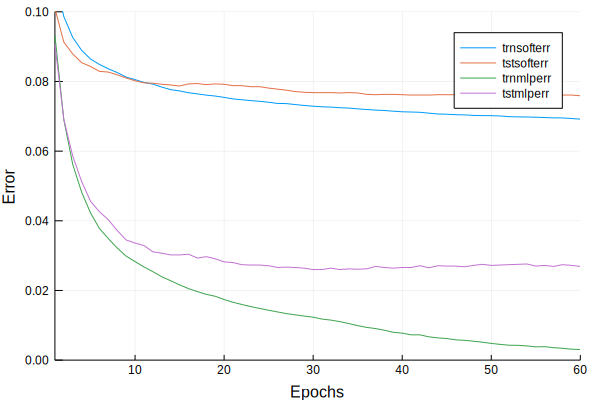

In [53]:
plot([trnsofterr tstsofterr trnmlperr tstmlperr],ylim=(.0,.10),labels=[:trnsofterr :tstsofterr :trnmlperr :tstmlperr],xlabel="Epochs",ylabel="Error")

In [54]:
# Cleanup
wmlp = mlpmodels = nothing; knetgc()

# CNN example with MNIST (The LeNet model)

In [55]:
# We only need to change the predict function!
function predict(w,x) # LeNet model
    n=length(w)-4
    for i=1:2:n
        x = pool(relu.(conv4(w[i],x) .+ w[i+1]))
    end
    for i=n+1:2:length(w)-2
        x = relu.(w[i]*mat(x) .+ w[i+1])
    end
    return w[end-1]*x .+ w[end]
end

predict (generic function with 1 method)

In [57]:
wcnn=map(Atype, [ 0.1*randn(5,5,1,20),  zeros(1,1,20,1), 
                  0.1*randn(5,5,20,50), zeros(1,1,50,1),
                  0.1*randn(500,800),  zeros(500,1),
                  0.1*randn(10,500),  zeros(10,1) ])
loss(wcnn, x, y)

4.1054115f0

## Train CNN model

In [58]:
@time cnnmodels = [ copy(train!(wcnn, dtrn)) for epoch=1:60 ]; # ~127 seconds

LoadError: [91mInterruptException:[39m

## Compare CNN loss with MLP

In [59]:
@time trncnnloss = [ nll(w,dtrn,predict) for w in cnnmodels ]; # ~48 seconds
@time tstcnnloss = [ nll(w,dtst,predict) for w in cnnmodels ]; # ~8 seconds

LoadError: [91mUndefVarError: cnnmodels not defined[39m

In [63]:
plot([trnsoftloss tstsoftloss trnmlploss tstmlploss trncnnloss tstcnnloss],ylim=(.0,.36),labels=[:trnsoftloss :tstsoftloss :trnmlploss :tstmlploss :trncnnloss :tstcnnloss],xlabel="Epochs",ylabel="Loss") 

LoadError: [91mUndefVarError: trncnnloss not defined[39m

## Compare CNN error with MLP

In [61]:
@time trncnnerr = [ 1-accuracy(w,dtrn,predict) for w in cnnmodels ]; # ~48 seconds
@time tstcnnerr = [ 1-accuracy(w,dtst,predict) for w in cnnmodels ]; # ~8 seconds

LoadError: [91mUndefVarError: cnnmodels not defined[39m

In [64]:
plot([trnsofterr tstsofterr trnmlperr tstmlperr trncnnerr tstcnnerr],ylim=(.0,.10),labels=[:trnsofterr :tstsofterr :trnmlperr :tstmlperr :trncnnerr :tstcnnerr],xlabel="Epochs",ylabel="Error")

LoadError: [91mUndefVarError: trncnnerr not defined[39m

ERROR (unhandled task failure): InterruptException:
Stacktrace:
 [1] process_events at ./libuv.jl:82 [inlined]
 [2] wait() at ./event.jl:216
 [3] wait(::Condition) at ./event.jl:27
 [4] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:42
 [5] wait(::Timer) at ./event.jl:357
 [6] (::Base.##300#301{IJulia.#send_stderr,Timer})() at ./event.jl:430


In [42]:
# Cleanup
wcnn = cnnmodels = nothing; knetgc()

# Shakespeare example

In [43]:
# Please see charlm.ipynb for training a character based language model on "The Complete Works of William Shakespeare"

# VGG example

In [44]:
include(Knet.dir("examples/vgg/vgg.jl"));

In [ ]:
caturl = "https://github.com/BVLC/caffe/raw/master/examples/images/cat.jpg"
catfile = download(caturl)
load(catfile)

In [47]:
VGG.main(catfile)

vgg.jl (c) Deniz Yuret, İlker Kesen, 2016. Classifying images with the VGG model from http://www.robots.ox.ac.uk/~vgg/research/very_deep.
opts=(:atype, "KnetArray{Float32}")(:top, 5)(:image, "/dev/shm/dyuret/.julia/v0.6/Knet/data/cat.jpg")(:model, "imagenet-vgg-verydeep-16")


INFO: Loading imagenet-vgg-verydeep-16.mat...


5×2 Array{Any,2}:
 0.27327    "tabby, tabby cat"        
 0.253185   "Egyptian cat"            
 0.248429   "tiger cat"               
 0.060727   "kit fox, Vulpes macrotis"
 0.0561707  "red fox, Vulpes vulpes"  

  5.173264 seconds (61.56 k allocations: 3.428 MiB, 81.30% gc time)


INFO: Classifying


In [48]:
VGG.main("https://cvimg1.cardekho.com/p/237x156/in/mahindra/torro-25/mahindra-torro-25.jpg")

vgg.jl (c) Deniz Yuret, İlker Kesen, 2016. Classifying images with the VGG model from http://www.robots.ox.ac.uk/~vgg/research/very_deep.
opts=(:atype, "KnetArray{Float32}")(:top, 5)(:image, "https://cvimg1.cardekho.com/p/237x156/in/mahindra/torro-25/mahindra-torro-25.jpg")(:model, "imagenet-vgg-verydeep-16")


INFO: Downloading https://cvimg1.cardekho.com/p/237x156/in/mahindra/torro-25/mahindra-torro-25.jpg
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13411  100 13411    0     0   6702      0  0:00:02  0:00:02 --:--:--  6705
INFO: Classifying


5×2 Array{Any,2}:
 0.899679    "garbage truck, dustcart"                                                   
 0.0654105   "moving van"                                                                
 0.0201083   "crane"                                                                     
 0.00583589  "trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi"
 0.00515393  "snowplow, snowplough"                                                      

  0.039080 seconds (1.85 k allocations: 90.297 KiB)

